In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from itertools import combinations, chain

from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import distance_metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc

from joblib import dump
from imblearn.over_sampling import SMOTE


In [3]:
data = pd.read_csv('../../../DATA/Concatination_of_ters/Without_Индекс стоимости жизни/classes.csv').dropna()


In [4]:
X, y = data.drop('Средняя численность работников, включая внешних совместителей',
                 axis=1), data['Средняя численность работников, включая внешних совместителей']
X_balanced, y_balanced = SMOTE().fit_resample(X, y)


In [5]:
X_balanced['Средняя численность работников, включая внешних совместителей'] = y_balanced


In [6]:
data_smoted = X_balanced

In [7]:
X_train_smoted, X_test_smoted, y_train_smoted, y_test_smoted = train_test_split(data_smoted.drop('Средняя численность работников, включая внешних совместителей', axis=1),
                                                    data_smoted['Средняя численность работников, включая внешних совместителей'], test_size=0.5, random_state=42)


In [8]:
knn_optimal_n_neighbors_by_f1 = RandomizedSearchCV(KNeighborsClassifier(),
                                                   {'n_neighbors': np.arange(1, 10, 2),
                                                    'weights': ['uniform', 'distance'],
                                                    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                                                    'p': np.arange(1, 10, 1),
                                                    'metric': list(distance_metrics().keys())
                                                    },
                                                   n_iter=12,
                                                   n_jobs=4,
                                                   scoring='f1',
                                                   random_state=71
                                                   ).fit(X_train_smoted, y_train_smoted)
knn_optimal_n_neighbors_by_f1.best_params_


c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neigh

{'weights': 'distance',
 'p': 6,
 'n_neighbors': 1,
 'metric': 'l1',
 'algorithm': 'brute'}

In [9]:
knn_optimal_n_neighbors_by_recall = RandomizedSearchCV(KNeighborsClassifier(),
                                                   {'n_neighbors': np.arange(1, 10, 2),
                                                    'weights': ['uniform', 'distance'],
                                                    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                                                    'p': np.arange(1, 10, 1),
                                                    'metric': list(distance_metrics().keys())
                                                    },
                                                   n_iter=12,
                                                   n_jobs=4,
                                                   scoring='recall',
                                                   random_state=71
                                                   ).fit(X_train_smoted, y_train_smoted)
knn_optimal_n_neighbors_by_f1.best_params_


c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neigh

{'weights': 'distance',
 'p': 6,
 'n_neighbors': 1,
 'metric': 'l1',
 'algorithm': 'brute'}

In [10]:
svc_optimal = GridSearchCV(SVC(),
                                       {'probability': [True, False],
                                        'C': np.arange(1.8, 1.9, 0.01),
                                        #   'tol': np.arange(0, 2e-3, 1e-4),
                                        # 'degree': np.arange(0, 2, 1),
                                        #   'gamma': ['scale'] + [*np.arange(0, 1, 0.1)],
                                        # 'coef0': np.arange(0, 0.2, 0.1),
                                        # 'shrinking': [True, False],
                                        # 'break_ties': [True, False],
                                        'decision_function_shape': ['ovo', 'ovr'],
                                        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
                                       n_jobs=6,
                                       scoring='recall',
                                       cv=3
                                       ).fit(X_train_smoted, y_train_smoted)
svc_optimal.best_params_


{'C': 1.8,
 'decision_function_shape': 'ovo',
 'kernel': 'linear',
 'probability': True}

# Recall

In [11]:
stacking_classifie_optimall_params = GridSearchCV(StackingClassifier([('knn_f1', knn_optimal_n_neighbors_by_f1), 
                                                                      ('knn_recall', knn_optimal_n_neighbors_by_recall), 
                                                                      ('svc', svc_optimal)]),
                                                  {'stack_method': ['predict_proba', 'decision_function', 'predict']},
                                                  n_jobs=6,
                                                  scoring='recall',
                                                  cv=3
                                                  ).fit(X_train_smoted, y_train_smoted)
stacking_classifie_optimall_params.best_params_


c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_stacking.py", line 660, in fit
    return super().fit(X, y_encoded, sample_weight)
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-package

{'stack_method': 'predict'}

In [12]:
y_predicted = stacking_classifie_optimall_params.predict(X_test_smoted)


In [13]:
print(confusion_matrix(y_test_smoted, y_predicted))


[[30 11]
 [14 33]]


In [14]:
print(classification_report(y_test_smoted, y_predicted))


              precision    recall  f1-score   support

       False       0.68      0.73      0.71        41
        True       0.75      0.70      0.73        47

    accuracy                           0.72        88
   macro avg       0.72      0.72      0.72        88
weighted avg       0.72      0.72      0.72        88



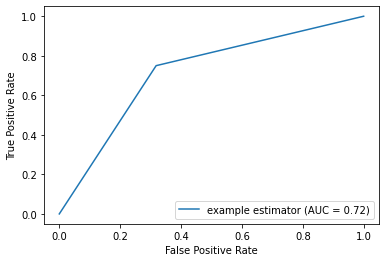

In [15]:
fpr, tpr, thresholds = roc_curve(y_predicted, y_test_smoted)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()


# F1

In [16]:
stacking_classifie_optimall_params = GridSearchCV(StackingClassifier([('knn_f1', knn_optimal_n_neighbors_by_f1), 
                                                                      ('knn_recall', knn_optimal_n_neighbors_by_recall), 
                                                                      ('svc', svc_optimal)]),
                                                  {'stack_method': ['predict_proba', 'decision_function', 'predict']},
                                                  n_jobs=4,
                                                  scoring='f1',
                                                  cv=3
                                                  ).fit(X_train_smoted, y_train_smoted)
stacking_classifie_optimall_params.best_params_


c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_stacking.py", line 660, in fit
    return super().fit(X, y_encoded, sample_weight)
  File "c:\Users\Mike\AppData\Local\Programs\Python\Python39\lib\site-package

{'stack_method': 'predict'}

In [17]:
y_predicted = stacking_classifie_optimall_params.predict(X_test_smoted)


In [18]:
print(confusion_matrix(y_test_smoted, y_predicted))


[[30 11]
 [14 33]]


In [19]:
print(classification_report(y_test_smoted, y_predicted))


              precision    recall  f1-score   support

       False       0.68      0.73      0.71        41
        True       0.75      0.70      0.73        47

    accuracy                           0.72        88
   macro avg       0.72      0.72      0.72        88
weighted avg       0.72      0.72      0.72        88



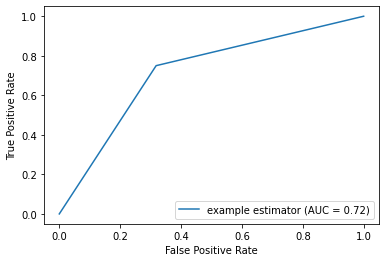

In [20]:
fpr, tpr, thresholds = roc_curve(y_predicted, y_test_smoted)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
